In [1]:
import os
import glob

import numpy as np
import pandas as pd

import xarray as xr
import geopandas as gpd

import clima_anom as ca

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

In [2]:
SP = gpd.read_file(os.path.join('..','geojson','SaoPaulo.geojson'))

In [3]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Brazil','GSMaP','1ho')

In [4]:
file_list = glob.glob(os.path.join(dir_base,'raw','*.nc'))
file_list = sorted(file_list)
file_len = len(file_list)
print(f'Number of files: {file_len}')

Number of files: 28


In [5]:
PRE = None
time_vector = []
for nn in range(file_len):
    DATA = xr.open_dataset(file_list[nn])
    if PRE is None:
        lat = DATA['lat'].data
        lon = DATA['lon'].data
        PRE = DATA['precipitation']
        time_vector = pd.DatetimeIndex(DATA['time'])

    else:
        PRE_tmp = DATA['precipitation']
        PRE = np.concatenate([PRE, PRE_tmp])
        time_tmp = pd.DatetimeIndex(DATA['time'])
        time_vector = np.concatenate([time_vector, time_tmp])

time_vector = pd.to_datetime(time_vector)

In [6]:
PRE_xr = xr.Dataset(data_vars={"PRE": (("time","lat","lon"), PRE.data)},
                    coords={'time': time_vector, 'lat': lat, 'lon': lon},
                    attrs=dict(description="GSMaP hourly data for South America"))

PRE_xr.PRE.attrs["units"] = "mm"
PRE_xr.lat.attrs["long_name"] = "Precipitation"

PRE_xr.lat.attrs["units"] = "degrees_north"
PRE_xr.lat.attrs["long_name"] = "Latitude"

PRE_xr.lon.attrs["units"] = "degrees_east"
PRE_xr.lon.attrs["long_name"] = "Longitude"

In [7]:
PRE_xr

<xarray.Dataset> Size: 812MB
Dimensions:  (time: 672, lat: 570, lon: 530)
Coordinates:
  * time     (time) datetime64[ns] 5kB 2023-02-01 ... 2023-02-28T23:00:00
  * lat      (lat) float64 5kB -44.95 -44.85 -44.75 -44.65 ... 11.75 11.85 11.95
  * lon      (lon) float64 4kB -84.95 -84.85 -84.75 ... -32.25 -32.15 -32.05
Data variables:
    PRE      (time, lat, lon) float32 812MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    description:  GSMaP hourly data for South America

In [8]:
yy_s = pd.to_datetime(time_vector[0]).year
mm_s = str(pd.to_datetime(time_vector[0]).month).zfill(2)
dd_s = str(pd.to_datetime(time_vector[0]).day).zfill(2)

yy_e = pd.to_datetime(time_vector[-1]).year
mm_e = str(pd.to_datetime(time_vector[-1]).month).zfill(2)
dd_e = str(pd.to_datetime(time_vector[-1]).day).zfill(2)

print(f'Start time: {dd_s}/{mm_s}/{yy_s}')
print(f'End time: {dd_e}/{mm_e}/{yy_e}')

Start time: 01/02/2023
End time: 28/02/2023


In [19]:
PRE_out = os.path.join(dir_base,f'GSMaP_Italy_1dy_{yy_s}_{mm_s}_{dd_s}_{yy_e}_{mm_e}_{dd_e}.nc')
print(f'Export PRE data to {PRE_out}')
PRE_xr.to_netcdf(PRE_out)

Export PRE data to /media/arturo/Arturo/Data/Brazil/GSMaP/1ho/GSMaP_Italy_1dy_2023_02_01_2023_02_28.nc


In [9]:
lon2d, lat2d = np.meshgrid(lon, lat)

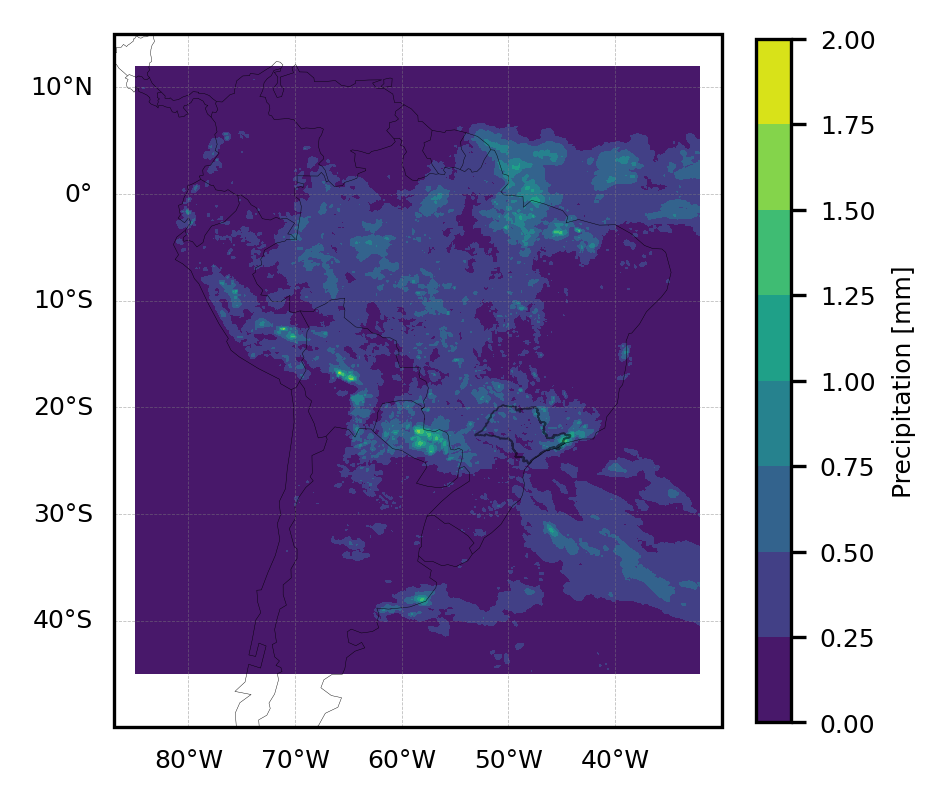

In [17]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(3,3),dpi=300)
gs = gridspec.GridSpec(1,1)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([-87,-30,-50,15],crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

ax1.add_geometries(SP.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.4, alpha=0.5)

a1 = ax1.contourf(lon2d, lat2d, np.nanmean(PRE,axis=0))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 6, 'color': 'k'}
gl.ylabel_style = {'size': 6, 'color': 'k'}

cbar = plt.colorbar(a1, orientation='vertical', pad=0.05, fraction=0.049)
cbar.set_label('Precipitation [mm]', fontsize=6)
cbar.ax.tick_params(labelsize=6)